# CUDA LAB - Project (Stereo Depth Estimation)
## Submitted By: Pahulmeet Singh (s6papahu@uni-bonn.de / pahulmeetsingh@gmail.com)
## ID: 3365755

## Required Libraries

In [1]:
import os
import random
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset

from torchvision import datasets, models, transforms
from PIL import Image
import cv2

from torchvision.utils import save_image

from torch.utils.tensorboard import SummaryWriter

In [2]:
import os
from load_data import CustomDataSet_disp as read_disparity
from load_data import CustomDataSet as read_kiti
from load_data import show_grid

from Regressor_and_loss import disparityregression
from Regressor_and_loss import loss_l1func
from Regressor_and_loss import loss_3pfunc

from Trainer_func import train_epoch

## Initialising the folder where the tensorboard logs are to be stored. 

In [3]:
tboard_LOGS = os.path.join(os.getcwd(), "tboard_logs", "dispar") #Folder location can be changed here
if not os.path.exists(tboard_LOGS):
    os.makedirs(tboard_LOGS)
shutil.rmtree(tboard_LOGS)               #Removes Exisiting log file
writer = SummaryWriter(tboard_LOGS)

## Parameters

In [4]:
B=1           #Batch Size
C=32          #Input Channels to 3D-cost volume
H=256         #Height of Image
W=512         #Width of image
eps_num = 500 #Epochs

loss_func = loss_l1func

## Data Pre-Processing

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,512)),
    ]),
    'no_train0': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),
    ]),
    'no_train1': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.RandomEqualize(p=0.9),
        transforms.ToTensor(),
    ]),
    'no_train2': transforms.Compose([
        transforms.ColorJitter(brightness=.3, hue=.3),
        transforms.Resize((256,512)),
        transforms.ToTensor(),
    ]),
    'no_train3': transforms.Compose([
        transforms.RandomSolarize(threshold=50.0),
        transforms.Resize((256,512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    'no_train4': transforms.Compose([
        transforms.Resize((256,512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])}

## Loading the training datasets

In [74]:
data_dir = 'data/scene_flow/image_2' #folder where training dataset is stored of first 150 images 
my_dataset = read_kiti(data_dir, transform=data_transforms['no_train0'])
im2_train = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False)
data_dir = 'data/scene_flow/image_3' #folder where training dataset is stored of first 150 images
my_dataset = read_kiti(data_dir, transform=data_transforms['no_train0'])
im3_train = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False)

In [75]:
data_dir = 'data/scene_flow/disp_occ_0' #folder where left disparity is stored of first 150 images
my_dataset = read_disparity(data_dir, transform=data_transforms['train'])
disp_train = torch.utils.data.DataLoader(my_dataset , batch_size=B, shuffle=False)

## Loading the testing datasets

In [76]:
data_dir = 'data/scene_flow/im2_val'
my_dataset = read_kiti(data_dir, transform=data_transforms['no_train0'])
im2_val = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False)

data_dir = 'data/scene_flow/im3_val'
my_dataset = read_kiti(data_dir, transform=data_transforms['no_train0'])
im3_val = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False)

data_dir = 'data/scene_flow/disp_val'
my_dataset = read_disparity(data_dir, transform=data_transforms['train'])
disp_val = torch.utils.data.DataLoader(my_dataset , batch_size=1, shuffle=False)

## Visualising the Training Data

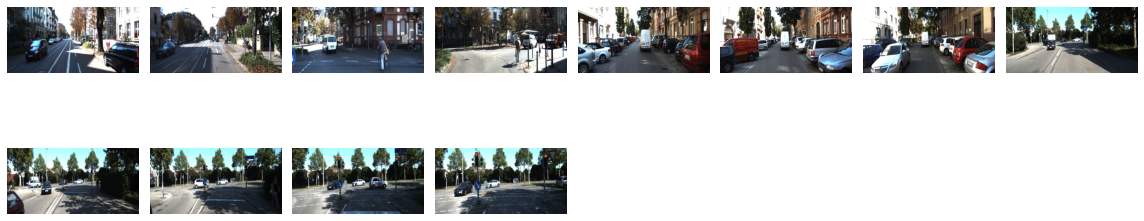

In [77]:
data_dir = 'data/scene_flow/image_2'
my_dataset = read_kiti(data_dir, transform=data_transforms['no_train0'])
train_loader = torch.utils.data.DataLoader(my_dataset , batch_size=12, shuffle=False)
inputs = iter(train_loader)
first = next(inputs)
show_grid(first)

## Setting the device as cuda as the models will take forever to run on a CPU

In [10]:
device = "cuda"
torch.cuda.empty_cache()

In [79]:
def saving_im(iter_val, im_path):
    im_L_iter = iter(im2_train)
    im_R_iter = iter(im3_train)
    
    counter = 0
    with torch.no_grad():
        for counter in range(1):
            im_L = next(im_L_iter)
            im_R = next(im_R_iter)

            left_im = im_L
            left_im = left_im.to(device)

            right_im = im_R
            right_im = right_im.to(device)

            recons = model(left_im,right_im)

            x_hat=recons.cpu().detach().numpy()
            x_hat = x_hat[0]
           
            x_hat=np.transpose(x_hat,(1,2,0))
            x_hat = x_hat[:,:,0]
            plt.figure(figsize=(7, 15))
            im_path1 = im_path+"imgs_"+str(iter_val)+".png"
            matplotlib.image.imsave(im_path1, x_hat)
            plt.imshow(x_hat)

## The Model to use

In [8]:
from model8 import create_mod
from model8 import baseline_model

In [13]:
newmodel = create_mod()

In [14]:
model = baseline_model(B,C,H,W,newmodel)

In [15]:
model = model.to(device)

In [16]:
print(model.cnn_Shared)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [17]:
print(model.cnn_3dims)

Sequential(
  (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (7): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (10): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (13): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1)

## Optimizer and Scheduler

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, mode='min', factor=0.5)

# NOTE: Skip the next step if you want to view visualisations of a trained model

## Running for as many epochs as required

In [ ]:
losses_total = []
iters = 0

im_path = os.path.join(os.getcwd(), "save_ims") #Folder location can be changed here
if not os.path.exists(im_path):
    os.makedirs(im_path)

for i in range(eps_num):
    loss_list, iters = train_epoch(model, B, im2_train, im3_train, disp_train, optimizer, loss_func, device, iters, i,writer)
    if(i%5==0):
        saving_im(i,im_path)
    loss_mean = sum(loss_list)/len(loss_list)
    losses_total.append(loss_mean)
    writer.add_scalar(f'Loss/Epoch Loss', loss_mean, global_step=i)
    print('EPOCH NUMBER: ', i+1, " and loss = ", loss_mean)
    scheduler.step(loss_mean)
    loss_list.clear()

# Loading a saved model anfd Visualizing Trained and Testing Images

In [11]:
from model8 import create_mod
from model8 import baseline_model

PATH="disparity_model/final_dict3.pth"
newmodel = create_mod()
model = baseline_model(B,C,H,W,newmodel)
model.load_state_dict(torch.load(PATH))
model = model.to(device)

## Model with a combination of pretrained VGG and r3d18 for pretrained 3D-CNN

In [82]:
"""from model6 import create_mod
from model6 import baseline_model

PATH="disparity_model/vgg_res3d_dict2.pth"
newmodel,model3d = create_mod()
model = baseline_model(B,C,H,W,newmodel,model3d)
model.load_state_dict(torch.load(PATH))
model = model.to(device)"""

## A simple model with no pretraining

In [ ]:
"""from model2 import baseline_model

PATH="disparity_model/small_kernels_dict1.pth"
model = baseline_model(B,C,H,W)
model.load_state_dict(torch.load(PATH))
model = model.to(device)"""

## Reconstructing Training Images

In [61]:
#origin
which_num = 0 # State which index image you want to visualise

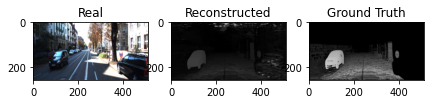

In [62]:
#origin
im_L_iter = iter(im2_train)
im_R_iter = iter(im3_train)
im_d_iter2 = iter(disp_train)
im_a_iter = iter(im2_train)


counter = 0
with torch.no_grad():
    for counter in range(1):
        im_L = next(im_L_iter)
        im_R = next(im_R_iter)
        im_D = next(im_d_iter2)
        im_a = next(im_a_iter)
        for j in range(which_num):
            im_L = next(im_L_iter)
            im_R = next(im_R_iter)
            im_D = next(im_d_iter2)
            im_a = next(im_a_iter)
        left_im = im_L
        left_im = left_im.to(device)

        right_im = im_R
        right_im = right_im.to(device)

        recons = model(left_im,right_im)
        
        x_hat=recons.cpu().detach().numpy()
        x_hat = x_hat[0]
        #print(x_hat)
        x_hat=np.transpose(x_hat,(1,2,0))
        
        
        x_hat5 = im_a[0]
        x_hat5=np.transpose(x_hat5,(1,2,0))
        
        plt.figure(figsize=(7, 15))
        plt.subplot(1,3,1)
        plt.title("Real")
        x_hat1 = im_a[0]
        plt.imshow(x_hat5)
        plt.subplot(1,3,2)
        plt.title("Reconstructed")
        plt.imshow(x_hat, cmap = "gray")
        plt.subplot(1,3,3)
        plt.title("Ground Truth")
        x_hat1 = im_D[0]
        plt.imshow(x_hat1, cmap="gray")
        

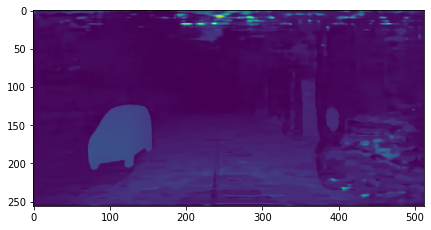

In [63]:
im_L_iter = iter(im2_train)
im_R_iter = iter(im3_train)
counter = 0
with torch.no_grad():
    for counter in range(1):
        im_L = next(im_L_iter)
        im_R = next(im_R_iter)
        for j in range(which_num):
            im_L = next(im_L_iter)
            im_R = next(im_R_iter)
        left_im = im_L
        left_im = left_im.to(device)

        right_im = im_R
        right_im = right_im.to(device)

        recons = model(left_im,right_im)
        
        x_hat=recons.cpu().detach().numpy()
        x_hat = x_hat[0]
        #print(x_hat)
        x_hat=np.transpose(x_hat,(1,2,0))
        
        #im = Image.fromarray(x_hat)
        #im.save("your_file.png")
        plt.figure(figsize=(7, 15))
        plt.imshow(x_hat)

## Ground Truth Images

torch.Size([256, 512])


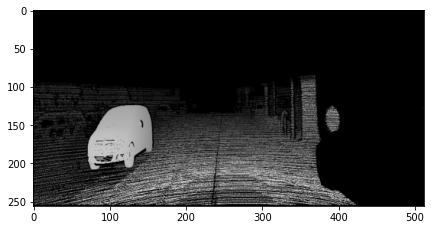

In [64]:
im_d_iter1 = iter(disp_train)
im_d = next(im_d_iter1)
for j in range(which_num):
    im_d = next(im_d_iter1)
x_hat = im_d[0]
#x_hat=np.transpose(x_hat,(1,2,0))
#x_hat = x_hat[:,:,0]
print(x_hat.shape)
plt.figure(figsize=(7, 15))
plt.imshow(x_hat, cmap="gray")

## Reconstructing Testing Images

In [65]:
which_num2 = 30 # State which index image you want to visualise

<Figure size 504x1080 with 0 Axes>

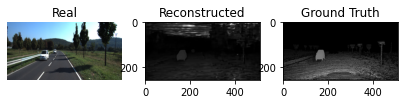

In [66]:
#origin
im_L_iter = iter(im2_val)
im_R_iter = iter(im3_val)
im_d_iter2 = iter(disp_val)
im_a_iter = iter(im2_val)
counter = 0
with torch.no_grad():
    for counter in range(1):
        im_L = next(im_L_iter)
        im_R = next(im_R_iter)
        im_D = next(im_d_iter2)
        im_a = next(im_a_iter)
        for j in range(which_num2):
            im_L = next(im_L_iter)
            im_R = next(im_R_iter)
            im_D = next(im_d_iter2)
            im_a = next(im_a_iter)
        left_im = im_L
        left_im = left_im.to(device)

        right_im = im_R
        right_im = right_im.to(device)

        recons = model(left_im,right_im)
        
        x_hat=recons.cpu().detach().numpy()
        x_hat = x_hat[0]
        #print(x_hat)
        x_hat=np.transpose(x_hat,(1,2,0))
        x_hat5 = im_a[0]
        x_hat5=np.transpose(x_hat5,(1,2,0))
        
        plt.figure(figsize=(7, 15))
        
        x_hat5 = im_a[0]
        x_hat5=np.transpose(x_hat5,(1,2,0))
        
        plt.figure(figsize=(7, 15))
        plt.subplot(1,3,1)
        plt.axis("off")
        plt.title("Real")
        x_hat1 = im_a[0]
        plt.imshow(x_hat5)
        plt.subplot(1,3,2)
        plt.title("Reconstructed")
        plt.imshow(x_hat, cmap = "gray")
        plt.subplot(1,3,3)
        plt.title("Ground Truth")
        x_hat1 = im_D[0]
        plt.imshow(x_hat1, cmap="gray")
        

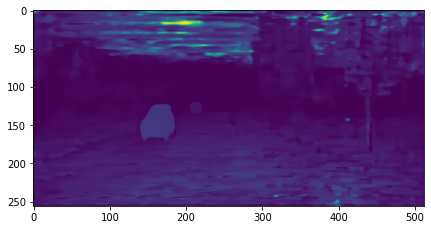

In [67]:
im_L_iter = iter(im2_val)
im_R_iter = iter(im3_val)
counter = 0
with torch.no_grad():
    for counter in range(1):
        im_L = next(im_L_iter)
        im_R = next(im_R_iter)
        for j in range(which_num2):
            im_L = next(im_L_iter)
            im_R = next(im_R_iter)
        left_im = im_L
        left_im = left_im.to(device)

        right_im = im_R
        right_im = right_im.to(device)

        recons = model(left_im,right_im)
        
        x_hat=recons.cpu().detach().numpy()
        x_hat = x_hat[0]
        #print(x_hat)
        x_hat=np.transpose(x_hat,(1,2,0))
        
        #im = Image.fromarray(x_hat)
        #im.save("your_file.png")
        plt.figure(figsize=(7, 15))
        plt.imshow(x_hat)

## Corresponding Ground Truth Image

torch.Size([256, 512])


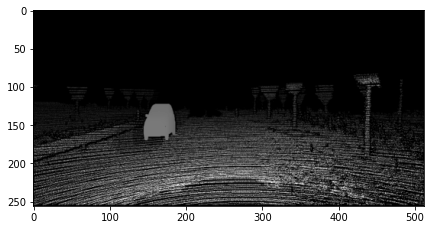

In [68]:
im_d_iter1 = iter(disp_val)
im_d = next(im_d_iter1)
for j in range(which_num2):
    im_d = next(im_d_iter1)
x_hat = im_d[0]
#x_hat=np.transpose(x_hat,(1,2,0))
#x_hat = x_hat[:,:,0]
print(x_hat.shape)
plt.figure(figsize=(7, 15))
plt.imshow(x_hat, cmap="gray")

## For Saving the Model

In [ ]:
torch.save(model, "dispar_1.pth")
torch.save(model.state_dict(), "dispar_dict1.pth")

# Observations and Inference

### 1) The model needed pretraining on sceneflow dataset.
### 2) There was a discrepansy with the Smoothl1loss function i.e. if for calculating mean using "N" only non-zero pixels were to be used then the loss is close 3.89. However, if all pixels were used for "N" then loss is close to 1.99. But using only non-zero values make more sense to me at the moment and due to which my model results are off from the 1.1 margin.
### 3) Some more models could have been tested with different pre-trained models for both 2D and 3D-CNNs.
### 4) More parameter optimization was required to deal with the frequent plateus.
### 5) On a positive note, the model seems to be learning the disparity concept as it achieved some nice results on images here and thereby completing the Stereo Depth Estimation Project.
